# Image Classification with BoVW

## Objective

The fundamental purpose of this phase of the project lies in the implementation of an image classification program based on the technique known as Bag of Visual Words (BoVW). This technique is widely used in computer vision and image processing for object recognition and visual content classification tasks. The process is broken down into several essential stages:

### Project Steps

#### 1. Division of the Data Set

First, the data set will be divided into two fundamental subsets: one for training and the other for validation. This division is essential to ensure that the classification model is properly and objectively evaluated on data it has not previously seen.

#### 2. Creation of a "Visual Dictionary"

This phase involves a series of critical steps. It starts with the extraction of relevant features from the images in the training set. The extracted features are then grouped into sets to form what is known as “visual words” or “visual dictionary.” The centers of these groups will be determined, which is equivalent to defining the visual words that will represent the characteristics of the data set. Once the visual dictionary has been established, we proceed to encode the images in the training data set using these visual words. This involves mapping each feature of an image to the closest visual word in the dictionary. The resulting encoding represents an image based on the frequency of the visual words in it.

#### 3. Classifier Training

The encoded features and training data set will be used to train a classifier. Common classifiers for image classification tasks include Support Vector Machines (SVM) or convolutional neural networks (CNN). The goal is for the classifier to learn to distinguish classes or categories of images using the information provided by the BoVW encoding.

#### 4. Classifier validation

Finally, the trained classification model is used to classify new images into specific categories. This involves extracting features from the new images, encoding them using the previously constructed visual dictionary, and using the classifier to assign them to a specific category.

This BoVW-based approach represents a robust methodology for image classification, with applications ranging from object recognition to visual content identification in fields such as medicine and security. The success of this phase of the project lies in the precision of the classifier and the robustness of the visual dictionary built.

## Code solution:

### Library Import:

In [3]:
import cv2
import os
import random
import numpy as np
import shutil
import matplotlib.pyplot as plt
from brisque import BRISQUE
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC

### Definition of directories:

In [4]:
carpeta_origen = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\TodosGatosPerrosRenombrados\\TodosGatosPerros' 
input_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\pgi2'
output_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\pgo2'
train_directory = r'C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V'
train_dir = r"C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V\\train"
val_dir = r"C:\\Users\\zunqu\\Desktop\\cosas de la escuela\\septimo semestre\\vision\\GatosyPerrosSalidaT&V\\val"

### Enhancement (preprocessing)

In [5]:
if not os.path.exists(input_directory):
    os.makedirs(input_directory)

archivos_en_carpeta = os.listdir(carpeta_origen)
imagenes = [archivo for archivo in archivos_en_carpeta if archivo.endswith(('.jpg', '.jpeg', '.png'))]

if len(imagenes) < 100:
    print("There are not enough images in the source folder.")
else:
    imagenes_seleccionadas = random.sample(imagenes, 100)

    for i, imagen in enumerate(imagenes_seleccionadas):
        origen = os.path.join(carpeta_origen, imagen)
        destino = os.path.join(input_directory, f'{imagen}') 
        shutil.copy(origen, destino)

    print("images have been copied and renamed to the destination folder.")

if not os.path.exists(output_directory):
    os.makedirs(output_directory)

image_files = os.listdir(input_directory)

max_size = 1000

def aumentar_saturacion(imagen, factor_saturacion):
    imagen_hsv = cv2.cvtColor(imagen, cv2.COLOR_BGR2HSV)
    imagen_hsv[:,:,1] = np.clip(imagen_hsv[:,:,1] * factor_saturacion, 0, 255).astype(np.uint8)
    imagen_vibrante = cv2.cvtColor(imagen_hsv, cv2.COLOR_HSV2BGR)

    return imagen_vibrante


def unsharp_mask(image, kernel_size=(9, 9), sigma=1, amount=1, threshold=95):
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = cv2.addWeighted(image, 1 + amount, blurred, -amount, 0)
    sharpened = np.where(sharpened > threshold, sharpened, image)
    return sharpened

def enhance_and_resize_image(image):
    if image is not None:

        yuv_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

        clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(4, 4))

        yuv_image[:,:,0] = clahe.apply(yuv_image[:,:,0])
        enhanced_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2BGR) 
        

        height, width = enhanced_image.shape[:2]
        if height > width:
            new_height = max_size
            new_width = int(width * (max_size / height))
        else:
            new_width = max_size
            new_height = int(height * (max_size / width))

        resized_image = cv2.resize(enhanced_image, (new_width, new_height), interpolation=cv2.INTER_NEAREST_EXACT) 
        resized_image = cv2.bilateralFilter(resized_image, d=30, sigmaColor=10, sigmaSpace=15)
        resized_image = unsharp_mask(resized_image)
        resized_image = aumentar_saturacion(resized_image, factor_saturacion= 1.95)
        

        return resized_image
    else:
        return None
   
brisque_scores = []
image_count = 0

for image_file in tqdm(image_files, desc="Processing images"):
    image_path = os.path.join(input_directory, image_file)
    image = cv2.imread(image_path)

    enhanced_image = enhance_and_resize_image(image)

    if enhanced_image is not None:
        output_path = os.path.join(output_directory, image_file)
        cv2.imwrite(output_path, enhanced_image)

        obj = BRISQUE()
        score = obj.score(enhanced_image)
        #print(f"Puntaje BRISQUE para {image_file}: {score}")
        brisque_scores.append(score)
        image_count += 1

if brisque_scores:
    mean_brisque_score = sum(brisque_scores) / len(brisque_scores)
    print(f"Average BRISQUE score for all resized and processed images: {mean_brisque_score}")

images have been copied and renamed to the destination folder.


Processing images: 100%|██████████| 191/191 [04:44<00:00,  1.49s/it]

Average BRISQUE score for all resized and processed images: 19.92123128616903


### Division of the Data Set


In [6]:
os.makedirs(train_directory, exist_ok=True)
image_files = os.listdir(output_directory)
random.shuffle(image_files)

# Define the ratio for splitting the dataset
train_ratio = 0.6
val_ratio = 0.4

# Split the image files into training and validation sets
train_files, val_files = train_test_split(image_files, test_size=val_ratio, random_state=42)


train_dir = os.path.join(train_directory, 'train')
val_dir = os.path.join(train_directory, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for file in train_files:
    src_path = os.path.join(output_directory, file)
    dst_path = os.path.join(train_dir, file)
    shutil.copy2(src_path, dst_path)  
    
for file in val_files:
    src_path = os.path.join(output_directory, file)
    dst_path = os.path.join(val_dir, file)
    shutil.copy2(src_path, dst_path)  

print(f"Total images: {len(image_files)}")
print(f"Training images: {len(train_files)}")
print(f"Validation images: {len(val_files)}")

Total images: 194
Training images: 116
Validation images: 78


### Visual Vocabulary

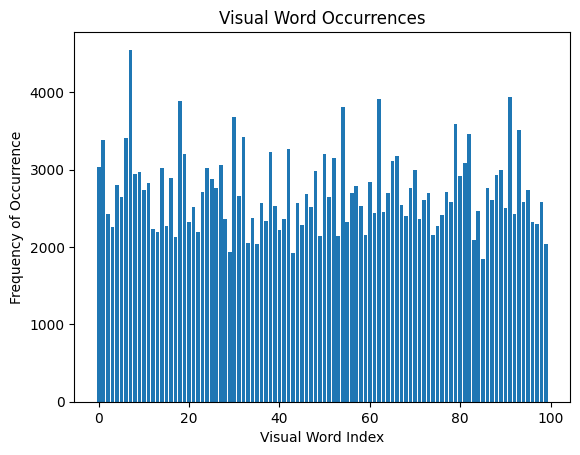

Done


In [7]:

# Parameters for SIFT and BoVW
sift = cv2.SIFT_create()
K = 100  

# Load the training images and extract SIFT descriptors
all_descriptors = []
for filename in os.listdir(train_dir):
    if filename.endswith('.jpg'):
        img_path = os.path.join(train_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) 
        kp, des = sift.detectAndCompute(img, None)
        if des is not None:
            all_descriptors.extend(des)

# Check if descriptors contain NaN or infinite values 
if np.any(np.isnan(all_descriptors)) or np.any(np.isinf(all_descriptors)):
    raise ValueError("Descriptors contain NaN or infinite values.")

# Check if K is greater than 0
if K <= 0:
    raise ValueError("The number of clusters K must be greater than 0.")

# Perform k-means clustering to create the visual vocabulary
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(np.float32(all_descriptors), K, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
vocabulary = centers

# Plot a histogram of visual word occurrences
histogram = np.bincount(labels.flatten(), minlength=K)
plt.bar(range(K), histogram)
plt.xlabel("Visual Word Index")
plt.ylabel("Frequency of Occurrence")
plt.title("Visual Word Occurrences")
plt.show()

# Save the vocabulary for later use if needed
np.save('visual_vocabulary.npy', vocabulary)

print("Done")

### Classifier training

In [8]:
# Load the visual vocabulary 
vocabulary = np.load('visual_vocabulary.npy')

# Function to compute visual word histograms for a set of images
def compute_histograms(images, vocabulary, sift):
    histograms = []
    K = len(vocabulary)

    for image_path in images:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        kp, des = sift.detectAndCompute(img, None)

        if des is not None:
            # Initialize a histogram with zeros
            histogram = np.zeros(K, dtype=int)

            # Assign each descriptor to the nearest visual word in the vocabulary
            for descriptor in des:
                distances = np.linalg.norm(descriptor - vocabulary, axis=1)
                nearest_visual_word_index = np.argmin(distances)
                histogram[nearest_visual_word_index] += 1

            histograms.append(histogram)

    return np.array(histograms)

# Load the training and validation images
train_images = [os.path.join(train_dir, filename) for filename in os.listdir(train_dir) if filename.endswith('.jpg')]
val_images = [os.path.join(val_dir, filename) for filename in os.listdir(val_dir) if filename.endswith('.jpg')]

# Create histograms for training images
train_histograms = compute_histograms(train_images, vocabulary, sift)

# Labels for training data (e.g., 1 for cats, 0 for dogs)
train_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(train_dir) if filename.endswith('.jpg')])

# Create an SVM classifier and train it
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_histograms, train_labels)

# Predict on the training set
train_predictions = svm_classifier.predict(train_histograms)

# Calculate accuracy for the training set
training_accuracy = accuracy_score(train_labels, train_predictions)
print(f"Training Accuracy: {training_accuracy * 100:.2f}%")

# Create a confusion matrix for the training set
confusion_mat = confusion_matrix(train_labels, train_predictions)
print("Confusion Matrix (Training Set):")
print(confusion_mat)

Training Accuracy: 100.00%
Confusion Matrix (Training Set):
[[55  0]
 [ 0 61]]


### Classifier valdiation 

In [11]:
# Train an SVM classifier
train_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(train_dir) if filename.endswith('.jpg')])
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(train_histograms, train_labels)

# Predict on the validation set
val_histograms = compute_histograms(val_images, vocabulary, sift)
val_labels = np.array([1 if "Gato" in filename else 0 for filename in os.listdir(val_dir) if filename.endswith('.jpg')])
val_predictions = svm_classifier.predict(val_histograms)

# Calculate accuracy
accuracy = accuracy_score(val_labels, val_predictions)
print(f"Validation Accuracy \n without filter {accuracy * 100:.2f}%")

# Create a confusion matrix for the validation set
confusion_mat = confusion_matrix(val_labels, val_predictions)
print("Confusion Matrix: ")
print(confusion_mat)

Validation Accuracy 
 without filter 66.67%
Confusion Matrix: 
[[27 14]
 [12 25]]


## Problem identification:
In this phase of the project we were able to identify the main characteristics to attack regarding this problem, which are:

- Classification of images into two categories: cats and dogs.
- Use of a Bag of Visual Words (BoVW) approach to represent images.
- Creation of a visual vocabulary to represent image features for classification.
- Training a Support Vector Machine (SVM) classifier for image classification.
- Evaluation of classifier performance using accuracy and a confusion matrix.


## Solution Formulation


#### **SIFT Feature Extraction (Step 2: Creation of a "Visual Dictionary"):**

- In "Step 2: Creation of a 'Visual Dictionary,'" we utilized the Scale-Invariant Feature Transform (SIFT) for feature extraction. SIFT was chosen due to its robustness to variations in scale, rotation, and illumination, making it suitable for image recognition.
- SIFT provides distinctive keypoint descriptors, a critical aspect for creating a "Visual Dictionary" in this context. These descriptors are essential for identifying local features in images, facilitating the creation of visual words.
- While "FAST" and "ORB" are efficient alternatives, our choice of SIFT aligns with the requirements of creating a comprehensive and accurate visual vocabulary.

#### **K-Means Clustering for Visual Vocabulary (Step 2: Creation of a "Visual Dictionary"):**

- For "Step 2: Creation of a 'Visual Dictionary,'" we employed K-Means clustering to group descriptors into visual words. K-Means was chosen for its simplicity and effectiveness in handling large datasets, contributing to the creation of the visual vocabulary.
- The algorithm's suitability for unsupervised learning tasks aligns with the nature of "Step 2," where we create the "Visual Dictionary" without requiring explicit labels.
- K-Means clustering is widely used in BoVW models for image classification and information retrieval tasks, making it an ideal choice for building the foundation of our visual vocabulary.

#### **Visual Vocabulary Size (K) (Step 2: Creation of a "Visual Dictionary"):**

- In "Step 2: Creation of a 'Visual Dictionary,'" the choice of the visual vocabulary size (K) was a crucial decision. We based this choice on experimentation and performance evaluation on the specific dataset, aligning with the objective of creating an effective "Visual Dictionary."
- We sought a balance between a smaller K, which reduces computational complexity, and a larger K, which captures more fine-grained image details. This choice directly impacts the quality of the "Visual Dictionary" and, consequently, the accuracy of classification in later steps.
- K=100 was selected as a reasonable compromise between computational efficiency and classification accuracy, ensuring that the "Visual Dictionary" captures the necessary level of detail while remaining manageable in terms of computational resources.

#### **SVM Classifier Selection (Step 3: Classifier Training):**

- To complete the "Classifier Training" step, we chose the Support Vector Machine (SVM) for its effectiveness in handling high-dimensional data, which is the case with image feature histograms.
- The selection of a linear kernel for the SVM aligns with our choice in "Step 1: Division of the Data Set." A linear kernel was preferred for its simplicity and efficiency in handling the BoVW representations.
- SVMs are known for their good generalization and robustness in image classification tasks, which is essential for accurate classification in "Step 4: Classifier Validation."

#### **Use of Linear Kernel SVM (Step 3: Classifier Training):**

- In "Step 3: Classifier Training," the choice of the linear kernel for the SVM aligns with our decision in "Step 1: Division of the Data Set" to use a linear kernel for simplicity and efficiency.
- The linear kernel simplifies the classification problem and improves computational efficiency, which is crucial in training the classifier effectively.
- Linear SVMs are often preferred in the context of BoVW representations as they perform well and are less prone to overfitting, which is a concern addressed in "Step 4: Classifier Validation."
- Non-linear kernels (e.g., RBF) were not initially preferred due to their higher complexity and potential overfitting, reinforcing our choice of a linear kernel in "Step 3."

#### **Evaluation Metrics (Accuracy and Confusion Matrix) (Step 4: Classifier Validation):**

- In "Step 4: Classifier Validation," we evaluate the performance of the classifier using accuracy as the primary evaluation metric, as established in the "Evaluation Metrics" section.
- Additionally, we employ a confusion matrix to gain deeper insights into the classifier's performance, as mentioned in the "Evaluation Metrics" section. The confusion matrix aids in distinguishing between true positive, true negative, false positive, and false negative predictions.
- These evaluation metrics collectively provide a comprehensive assessment of the classifier's performance on the validation dataset, fulfilling the objectives of "Step 4: Classifier Validation."

## Solutions Evaluation:

#### **Validation of accuracy and generalization:**

The primary metric for evaluating classifier performance on unseen data is validation accuracy. This metric reveals how well the model generalizes to images that have not been seen during training. The choice of using Support Vector Machine (SVM) with a linear kernel and Scale Invariant Feature Transform (SIFT) for feature extraction is based on the need to achieve high generalization on a specific task, such as dog classification and cats is due to several reasons:

- SIFT:
- IT is known for its ability to capture distinctive features, even in images of different breeds of dogs and cats, regardless of variations in subject size, orientation and lighting.
    - It is scale and rotation invariant, making it especially suitable for classifying images of animals in different poses and sizes.
    - The robustness and invariance of SIFT allow the SVM classifier to learn patterns representative of the categories "dog" and "cat" that are applicable to a variety of images of these two classes.
    - By avoiding using methods like FAST (which focuses on corner detection) or SURF (which has proprietary parts), we minimize the risk of losing important features in dog and cat images. Furthermore, it has been observed that ORB does not optimally perform feature extraction in this particular context, reinforcing the choice of SIFT as a strong option.
- SVM:
    - Is a supervised learning algorithm that is commonly used for classification problems. Its goal is to find a hyperplane that optimally separates samples of different classes in the feature space. The linear kernel is a kernel option in SVM that uses a linear hyperplane to perform separation.
    - In the context of cat and dog image classification, SVM with linear kernel works by finding a hyperplane (a line in the case of two-dimensional data) that best separates the features extracted from dog images from cat images. The "best separation" is defined as that which maximizes the margin between the two classes, that is, the distance between the hyperplane and the closest training samples of each class.
    - The linear kernel is a simple and efficient option for binary classification such as cats and dogs. This reduces the computational complexity compared to more complex nonlinear kernels such as the RBF (Radial Basis Function) kernel.
    - SVMs with linear kernels tend to be less prone to overfitting compared to nonlinear kernels, especially if we have a relatively small data set. This is important to prevent the model from overfitting the training data and having difficulty generalizing to new images of dogs and cats.
    - In the case of features extracted from images, the feature space can have high dimensionality. SVM with linear kernel is effective in high-dimensional spaces, which is crucial when working with histograms of image features.
    - SVMs with nonlinear kernels like the RBF kernel can capture more complex relationships in the data, but tend to be more prone to overfitting, especially with small data sets. This could lead to poor performance in classifying new images.

The choice of SVM with linear kernel in our case was based on its simplicity, efficiency, and ability to generalize well on a dog and cat image classification dataset, especially when compared to alternatives that might have been more prone to overfitting. or less efficient in high-dimensional feature spaces. This demonstrates careful consideration of the characteristics of the problem and the capabilities of the classification methods.

#### **Analysis of the Confusion Matrix:** 

The confusion matrix is a valuable tool for evaluating classifier performance in classification tasks. This matrix breaks down the model predictions into four categories:

- True Positives (TP): Represents instances where the model correctly predicted that an image is from a specific category (e.g., "dog") and the image actually belonged to that category.
- True Negatives (TN): Represents instances where the model correctly predicted that an image does not belong to a specific category and the image did not actually belong to that category.
- False Positives (FP): Represents instances where the model incorrectly predicted that an image belongs to a specific category when in fact it does not. That is, it predicted a "wrong category."
- False Negatives (FN): Represents instances where the model incorrectly predicted that an image does not belong to a specific category when in fact it does.

Strategic Use of SIFT in Analysis: The choice to use SIFT in the classification process plays a fundamental role in the analysis of the confusion matrix. Here's how:

- SIFT is known for its ability to detect and describe distinctive features in images, even subtle details that can differentiate one breed of dog or one type of cat from another. This reduces false positives by allowing the model to focus on relevant details.
- Using SIFT, the model can highlight unique characteristics of certain categories of cats or dogs that may be difficult to distinguish with other methods. This helps reduce false positives by correctly classifying images into specific categories, rather than making overly general predictions.
- Confusion matrix analysis provides detailed information about where the model is successful and where there may be difficulties. For example, if we observe a high false positive rate in a particular cat category, this could indicate that the model needs more data or an adjustment to the feature extraction for that particular category.

#### **Overfitting and Visual Vocabulary Size (K):**

The analysis of overfitting and the choice of the size of the visual vocabulary (K) are critical aspects in your project to achieve good generalization in image classification for the following reasons:

- Overfitting is a common concern in machine learning, where the model overfits the training data and has difficulty generalizing to unseen data, such as the validation set or new images. To mitigate these concerns, it is essential to evaluate the performance of the classifier on the validation set.
- The gap between training accuracy (how well the model performs on the data used to train) and validation accuracy (how well it performs on unseen data) is a key indicator of overfitting. If the training accuracy is significantly higher than the validation accuracy, it could be a sign that the model is overfitted and does not generalize well.
- The size of the visual vocabulary, represented as K, is an important parameter in the process of building a Bag of Visual Words (BoVW) model. K refers to the number of "visual words" or "clusters" in the vocabulary that are used to describe images.
- The value of K has a direct impact on the model's ability to discern relevant visual details in images. A larger K allows for greater granularity in image description, capturing finer details, but can also increase computational complexity.
- The choice of K = 100 is a strategic commitment. This means that a visual vocabulary of 100 keywords has been selected to describe the images. This specific choice is based on a balance between computational efficiency and classification accuracy.
- The value of K = 100 was considered appropriate as it provides enough power to capture distinctive features in dog and cat images without excessively increasing computational complexity. This helps avoid overfitting and ensures that the model can generalize effectively to new images.
- The choice of K is directly related to the generalization capacity of the model. An inappropriately large K could lead to overfitting, while a very small K could lose important information. The choice of K = 100 reflects careful consideration of these implications and seeks the appropriate balance.

#### **Runtime Efficiency and Variability:**

Consideration of runtime efficiency and evaluation of the solution under variable conditions are essential elements for the following reasons:

- Efficiency in execution time is a crucial aspect to take into account in our project. Refers to the time it takes to perform feature extraction, clustering, and classification operations in the image classification workflow. This is particularly relevant to achieving a solution that is scalable to large data sets or real-time applications.
- For projects that involve image classification, it is essential that the process be efficient, even when working with large volumes of data. An efficient solution can quickly process large quantities of images, which is essential in applications such as searching for online images or analyzing large image repositories.
- Variability refers to the solution's ability to handle images that may vary in quality, lighting conditions, and minor distortions. This is important because real-world images can be captured in various conditions and may contain noise or imperfections.


## Application Resources:

#### **Machine Learning Libraries:**

- Utilized Python libraries like scikit-learn for implementing machine learning algorithms.
- Employed OpenCV for computer vision tasks, including feature extraction.

#### **Feature Extraction Methods:**

- Utilized the Scale-Invariant Feature Transform (SIFT) algorithm as the feature extraction method.
- Experimented with other feature extraction techniques such as ORB, FAST and SURF for performance comparison.

#### **Classification Algorithms:**

- Employed Support Vector Machines (SVM) with a linear kernel as the primary classification algorithm.
- Explored other classification algorithms like Random Forests, K-Nearest Neighbors, or Convolutional Neural Networks (CNNs) for benchmarking and comparison.

#### **Validation and Evaluation Metrics:**

- Employed metrics such as accuracy and confusion matrix to assess the classifier's performance.
- Conducted cross-validation to ensure robustness and avoid overfitting.

#### **Visual Vocabulary Creation:**

- Created a visual vocabulary using k-means clustering to represent image content effectively.

#### **Code Development Environment:**

- Developed and documented the project using Python and Jupyter Notebook, allowing for code readability and easy collaboration.

#### **Data Handling:**

- Loaded, preprocessed, and organized image datasets for training and validation.
- Generated histograms of visual word occurrences for each image to build feature vectors.

#### **Model Training and Evaluation:**

- Trained the classifier on labeled training data.
- Evaluated classifier performance on validation data, using metrics to measure accuracy and precision.

## References:

[1] Creating linear kernel SVM in Python. (2018). Retrieved from https://www.geeksforgeeks.org/creating-linear-kernel-svm-in-python/

[2] Gandhi, R. (2018). Support Vector Machine - Introduction to Machine Learning Algorithms. Retrieved from https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47

[3] Introduction to SURF (Speeded-Up Robust Features). (n.d.). Retrieved from https://docs.opencv.org/3.4/df/dd2/tutorial_py_surf_intro.html

[4] ORB (Oriented FAST and Rotated BRIEF). (n.d.). Retrieved from https://docs.opencv.org/3.4/d1/d89/tutorial_py_orb.html

[5] SIFT Interest Point Detector Using Python - OpenCV. (2023). Retrieved from https://www.geeksforgeeks.org/sift-interest-point-detector-using-python-opencv/

[6] Confusion Matrix. (n.d.). Retrieved from https://www.sciencedirect.com/topics/engineering/confusion-matrix#:~:text=A%20confusion%20matrix%20is%20a,performance%20of%20a%20classification%20algorithm.

[7] Ramírez, L. (2023). Algoritmo k-means: ¿Qué es y cómo funciona? Retrieved from https://www.iebschool.com/blog/algoritmo-k-means-que-es-y-como-funciona-big-data/

